(512, 512) 2196 54.608421325683594


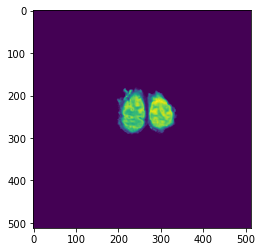

0 0 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 

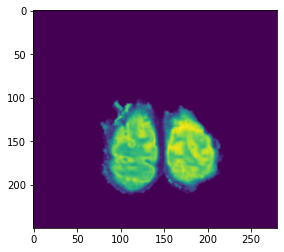

In [1]:
import pandas as pd
import numpy as np
import imageio    # save to PNG images
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file

repo_path = "/Users/milton/Documents/Academics/School/USF-MSCS\
/Machine Learning/project/rsna-miccai-brain-tumor-radiogenomic-classification"

# The path to a pydicom test dataset
img_path = repo_path + "/train/00005/FLAIR/Image-72.dcm"
ds = dcmread(img_path)
# `arr` is a numpy.ndarray
arr = ds.pixel_array

print(arr.shape, np.max(arr), np.mean(arr))
plt.imshow(arr)
plt.show()
p = arr[342]
print(np.max(p), p[222], p)
for i in p:
    if i > 0:
        print(i, np.where(p == i))
plt.imshow(arr[80:330,120:400])
plt.show()

In [2]:
from os import listdir
from os.path import isfile, isdir, join

def getScanNums(data_path):
    patients = (f for f in listdir(data_path) if isdir(join(data_path, f))) # Get all patient directories
    scan_nums = {}

    for patient in patients: # Iterate through the patients
        patient_scans = join(data_path, patient)
        scan_types = (f for f in listdir(patient_scans) if isdir(join(patient_scans, f)))
        for scan_type in scan_types: # Iterate through current patient's scan types
            scan = listdir(join(patient_scans, scan_type))
            if scan_type in scan_nums: # Get max num of scan per type from entire dataset
                scan_nums[scan_type] = (len(scan) if len(scan) > scan_nums[scan_type] else scan_nums[scan_type])
            else:
                scan_nums[scan_type] = len(scan)
    return scan_nums

In [3]:
train_path = repo_path + "/train"
test_path = repo_path + "/test"
    
print("Train: ", getScanNums(train_path))
print("Test: ", getScanNums(test_path))

Train:  {'FLAIR': 514, 'T1wCE': 400, 'T1w': 400, 'T2w': 472}
Test:  {'FLAIR': 412, 'T1wCE': 352, 'T1w': 352, 'T2w': 464}


In [4]:
def load_dicom(path):
    # read file
    dicom = pydicom.read_file(path)
    # get pixel data into a useful format. 
    data = dicom.pixel_array
    # transform data into black and white scale / grayscale
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def save_png_to_disk(data, path, png_master_dir):
    # SAVE PNG TO DISK     
    image_name=path.split('/')[4:][-1].split('.')[0]                               
    png_image_path=png_master_dir+'/'+'/'.join(path.split('/')[4:-1])+'/'+image_name+'.png'    
    imageio.imsave(png_image_path,data)
    
def convert_dicom_to_png(path, png_master_dir, resize = None):
    dicom = pydicom.read_file(path)
    data = apply_voi_lut(dicom.pixel_array, dicom)
    # If Resize == True, Resize Image to Specified Resolution
    if resize:
        data = cv2.resize(data, resize)
    # Transform Data as Necessary     
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    # SAVE PNG TO DISK     
    save_png_to_disk(data, path, png_master_dir)
    return data


In [5]:
def getScan(data_path):
    patients = (f for f in listdir(data_path) if isdir(join(data_path, f))) # Get all patient directories
    # df = {'ID':[], 'FLAIR':[], 'T1w':[], 'T1wCE':[], 'T2w':[]}
    df = {'ID':[], 'FLAIR':[]}
    for patient in patients: # Iterate through the patients
        df['ID'].append(patient)
        patient_scans = join(data_path, patient)
        scan_types = (f for f in listdir(patient_scans) if isdir(join(patient_scans, f)))
        for scan_type in scan_types: # Iterate through current patient's scan types
            patient_scan_types = join(patient_scans, scan_type)
            scans = listdir(patient_scan_types)
            scan_list = []
            for scan in scans:
                # The path to a pydicom test dataset
                ds = dcmread(join(patient_scan_types, scan))
                # `arr` is a numpy.ndarray
                px_arr = ds.pixel_array

                if np.mean(px_arr) > 50:
                    scan_list.append(list(px_arr))
                    # if len(scan_list) > 0:
                    #     scan_arr_list.append(list(px_arr))
                    # else:
                    #     scan_list.append(px_arr)
                    # scan_arr_list = (scan_arr_list + px_arr if len(scan_arr_list) > 0 else px_arr)
            df[scan_type].append(scan_list)
            
    return df

### Convert Images to Gray Scale

In [6]:
from pydicom.pixel_data_handlers.util import apply_voi_lut

def gray_scale(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)             
    data = dicom.pixel_array
    
    # depending on this value, X-ray may look inverted - fix that:
    # if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
    #     data = np.amax(data) - data
    
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

The img is : (512, 512) 255 0 6.318538665771484


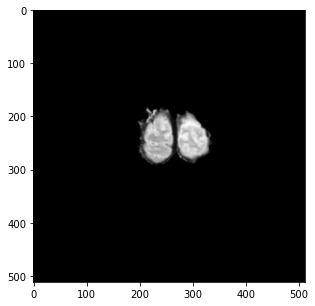

In [7]:
img = gray_scale(img_path)
plt.figure(figsize = (5,5))
plt.imshow(img, 'gray')
print("The img is :", img.shape, np.max(img), np.min(img), np.mean(img))

### Crop Images

In [8]:
def crop(img, padding):
    mi=np.array(np.nonzero(img)).min(axis=1)
    ma=np.array(np.nonzero(img)).max(axis=1)
    
    mi = [(mi[0] - padding), (mi[1] - padding)]
    ma = [(ma[0] + padding), (ma[1] + padding)]
    
    return img[mi[0]:ma[0],mi[1]:ma[1]]

(122, 153)

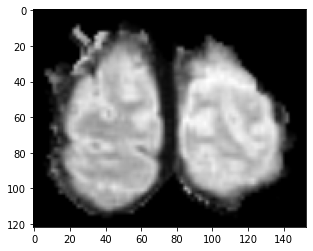

In [9]:
cropped_img = crop(img, 5)
plt.imshow(cropped_img, 'gray')
cropped_img.shape

In [10]:
# def getDims(data_path):
#     patients = (f for f in listdir(data_path) if isdir(join(data_path, f))) # Get all patient directories
#     scan_nums = {}

#     for patient in patients: # Iterate through the patients
#         patient_scans = join(data_path, patient)
#         scan_types = (f for f in listdir(patient_scans) if isdir(join(patient_scans, f)))
        
#         for scan_type in scan_types: # Iterate through current patient's scan types
#             patient_scan_types = join(patient_scans, scan_type)
#             scans = listdir(patient_scan_types)
#             scan_list = []
#             for scan in scans:
#                 # The path to a pydicom test dataset
#                 ds = dcmread(join(patient_scan_types, scan))
#                 # `arr` is a numpy.ndarray
#                 px_arr = ds.pixel_array
                
#                 for axis in range(4):
#                     for i in 

#                 if np.mean(px_arr) > 50:
#                     scan_list.append(list(px_arr))
                    
#             df[scan_type].append(scan_list)
            
#     return scan_nums